## Disney Princess or Avenger?
## Sade Korbieh
## IDSN 544, Fall 2024
## korbieh@usc.edu

In [1]:
## Looking for my princess and superheros

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
## installing duckduckgo
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of disney princesses and avengers

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        return [r['image'] for r in ddgs.images(keywords=term, max_results=max_images)]

Today, I want to find the distinction between if it is a Disney Princess or Marvel Avenger. First I am going to search and download images of disney princess from duckduckgo.com

Searching for 'Disney Princess'


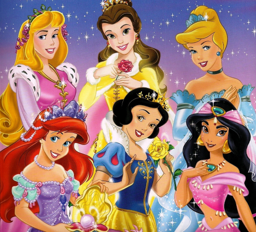

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Disney Princess', max_images=1)

if urls:
    # Download the image
    dest = 'disneyPrincess.jpg'  # Changed the filename to reflect the content
    download_url(urls[0], dest, show_progress=False)

    # Open and display the image
    im = Image.open(dest)
    display(im.to_thumb(256,256))
else:
    print("No images found.")

I now uploaded my image of a disney princess which at the end the model will decide if it is a disney princess or not

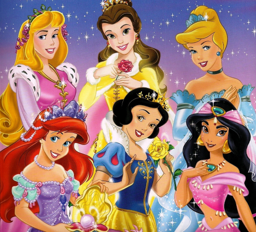

In [6]:
from fastdownload import download_url
dest = 'disneyPrincess.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Next, I will find images of marvel avengers to compare against disney princess

Searching for 'Marvel Avengers'


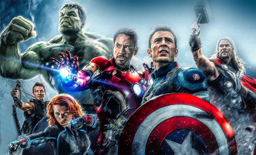

In [7]:
# First, let's get the image URL
urls = search_images('Marvel Avengers', max_images=1)

if urls:
    # Download the image
    dest = 'marvelAvenegers.jpg'  # Changed the filename to reflect the content
    download_url(urls[0], dest, show_progress=False)

    # Open and display the image
    im = Image.open(dest)
    display(im.to_thumb(256,256))
else:
    print("No images found.")

Now, label the images as either disney princess or marvel avenger

In [8]:
searches = 'Disney Princess','Marvel Avenger'
path = Path('disneyPrincess_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} character'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'Disney Princess character'
Searching for 'Marvel Avenger character'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

5 of the images it found do not work so they were deleted

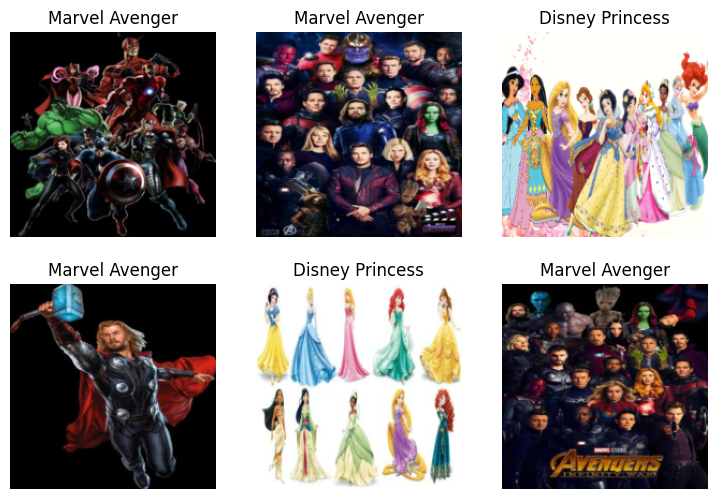

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.011509,0.526559,0.200000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.733295,0.382761,0.100000,00:00
1,0.817479,0.173962,0.100000,00:00
2,0.652851,0.107986,0.100000,00:00


## Step 3: Use our model (and build your own!)

The model will now classify the original image

In [12]:
is_disneyPrincess,_,probs = learn.predict(PILImage.create('disneyPrincess.jpg'))
print(f"This is a: {is_disneyPrincess}.")
print(f"Probability it's a Disney Princess: {probs[0]:.4f}")

This is a: Disney Princess.
Probability it's a Disney Princess: 0.9975


It was correct in the probability of it being a disney princess